## Tools

In [20]:
%pip install tensorflow[and-cuda]
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
    --------------------------------------- 0.1/9.3 MB 3.6 MB/s eta 0:00:03
   - -------------------------------------- 0.4/9.3 MB 5.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.8/9.3 MB 6.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/9.3 MB 7.9 MB/s eta 0:00:02
   -------- ------------------------------- 2.0/9.3 MB 8.9 MB/s eta 0:00:01
   ---------- ----------------------------- 2.3/9.3 MB 8.8 MB/s eta 0:00:01
   ------------ --------------------------- 2.9/9.3 MB 9.4 MB/s eta 0:00:01
   ------------- -------------------------- 3.2/9.3 MB 9.0 MB/s eta 0:00:01
   ---------------- ----------------------- 3.8/9.3 MB 9.2 MB/s eta 0:00:01
   ----------------- ---------------------- 4.1/9.3 MB 9.0 MB/s eta 0:00:01
   ------------------- -------------------- 4.5/9.3 MB 8.9 MB/s eta 0:00:01
   -------------------- ------------------- 4.9/9.3 MB 8.9 MB/s eta 0:00:01
   ----------------

In [2]:
import numpy as np # math library
import pandas as pd # dataframe library
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # graphing library that builds ontop of mathplot
import tensorflow as tf # machine learning library
from tensorflow import keras # computer vision library from tensorflow 
import pickle # module to seralize/de-seralize python objects to disk
import math
sns.set_style("darkgrid")
# Factor of reduction for colors bins, 1 means 1 bin per color value e.g. if factor = 1, num_bins = 255 a bin for each shade
FACTOR = 1

## Dataset
*Note: This is using a 5 class subset. The subset bird species are RUFOUS TREPE, HOUSE FINCH, D-ARNAUDS BARBET, OVENBIRD, ASIAN GREEN BEE EATER.
These 5 were choosen because they had the most available data out of the 500+ species in the orginial dataset.*

In [5]:
# training subset = RUFOUS TREPE, HOUSE FINCH, D-ARNAUDS BARBET, OVENBIRD, ASIAN GREEN BEE EATER
#csv format: class id,filepaths(relative),labels,data set(e.g. training,valid or test),scientific name
data = pd.read_csv("birds.csv")
data.head(10)

class id                            filepaths                 labels  \
0      40.0  train/ASIAN GREEN BEE EATER/162.jpg  ASIAN GREEN BEE EATER   
1      40.0  train/ASIAN GREEN BEE EATER/136.jpg  ASIAN GREEN BEE EATER   
2      40.0  train/ASIAN GREEN BEE EATER/153.jpg  ASIAN GREEN BEE EATER   
3      40.0  train/ASIAN GREEN BEE EATER/102.jpg  ASIAN GREEN BEE EATER   
4      40.0  train/ASIAN GREEN BEE EATER/145.jpg  ASIAN GREEN BEE EATER   
5      40.0  train/ASIAN GREEN BEE EATER/101.jpg  ASIAN GREEN BEE EATER   
6      40.0  train/ASIAN GREEN BEE EATER/105.jpg  ASIAN GREEN BEE EATER   
7      40.0  train/ASIAN GREEN BEE EATER/166.jpg  ASIAN GREEN BEE EATER   
8      40.0  train/ASIAN GREEN BEE EATER/106.jpg  ASIAN GREEN BEE EATER   
9      40.0  train/ASIAN GREEN BEE EATER/103.jpg  ASIAN GREEN BEE EATER   

  data set    scientific name  
0    train  MEROPS ORIENTALIS  
1    train  MEROPS ORIENTALIS  
2    train  MEROPS ORIENTALIS  
3    train  MEROPS ORIENTALIS  
4    train  MEROPS ORIENTALIS  
5    train  MEROPS ORIENTALIS  
6    train  MEROPS ORIENTALIS  
7    train  MEROPS ORIENTALIS  
8    train  MEROPS ORIENTALIS  
9    train  MEROPS ORIENTALIS

# Computer Vision
Convert an image to 3 histograms, one for each color channel. 
The histogram is condensed by default by a factor of 8 to reduce computation time(i.e. similar colors are grouped together).


In [6]:
def image_to_histograms(filepath,factor=8):
    # dynamically determine color bins based on factor which determines how many colors are being grouped together
    nbins = math.ceil(255 / factor)

    # load image into computer vision using native image size(this data set has an universal image size)
    image = tf.keras.utils.load_img(filepath)
    # the image is 224x224x3 (width x height x color_channels)
    image_array = tf.keras.utils.img_to_array(image,data_format='channels_last')
    # group pixel colors into bins
    bin_array = image_array // factor
    # 3D Slice colstart:colstop, rowstart:rowstop, depthstart:depthstop
    # Splitting the image_array into R, G, B channels
    red_channel = bin_array[:, :, 0]
    green_channel = bin_array[:, :, 1]
    blue_channel = bin_array[:, :, 2]

    # Create histograms data strucutre for each channel group (255 // 8 = 32)
    # x_hist = array, x_bins = bins start indexes in said array
    # note, since each color group has it's own bin, each index i corresponds to bin i making x_bins variable redundant.
    red_hist, _ = np.histogram(red_channel, bins=nbins, range=(0, nbins))
    green_hist, _ = np.histogram(green_channel, bins=nbins, range=(0, nbins))
    blue_hist, _ = np.histogram(blue_channel, bins=nbins, range=(0, nbins))
    return [red_hist,green_hist,blue_hist]



# Preprocessing & Caching
Run through the images and write their histogram to disk.
Add/update spreadsheet column with index that points to the image's histograms that are stored on disk.
This will make the data easier to access later for Naive Bayes.

In [7]:
#TODO: Storage test works, now I just need to get a scheme to track which images they belong to and add/upate a column in spreadsheet

def Cache_Histogram(data,factor=8):
    # master list of image histograms, each index i contains the histograms of the ith image
    image_histograms = []
    # add column to track index of histograms
    # -1 means null in this case.
    data['histogram_index'] = -1
    for index, row in data.iterrows():
        # read filepath col of the given row
        filepath = row['filepaths']
        
        
        # turn image into 3 histograms, each histogram covering a color channel of the pixels
        # save to master list, so it can seralized in one data structure later
        image_histograms.append([image_to_histograms(filepath,factor)])
        
        # add index corresponding to image_histogram index
        data.at[index,'histogram_index']= index
        
    # peserve the data set by creating another spreadsheet with the new column
    # the idea is this new spreadsheet now contains the cached value
    data.to_csv("birds_indexed.csv")

    # Saving the list to disk using pickle
    with open('image_histograms.pkl', 'wb') as file:
        pickle.dump(image_histograms, file)
        
    #Loading the list from the disk
    with open('image_histograms.pkl', 'rb') as file:
        loaded_histogram_list = pickle.load(file)
        
Cache_Histogram(data,FACTOR)


# Basic Exploratory Data Analysis (EDA)
The values of one pixel is inherintly indepedent of another. So I skipped the heat map that proves independence.

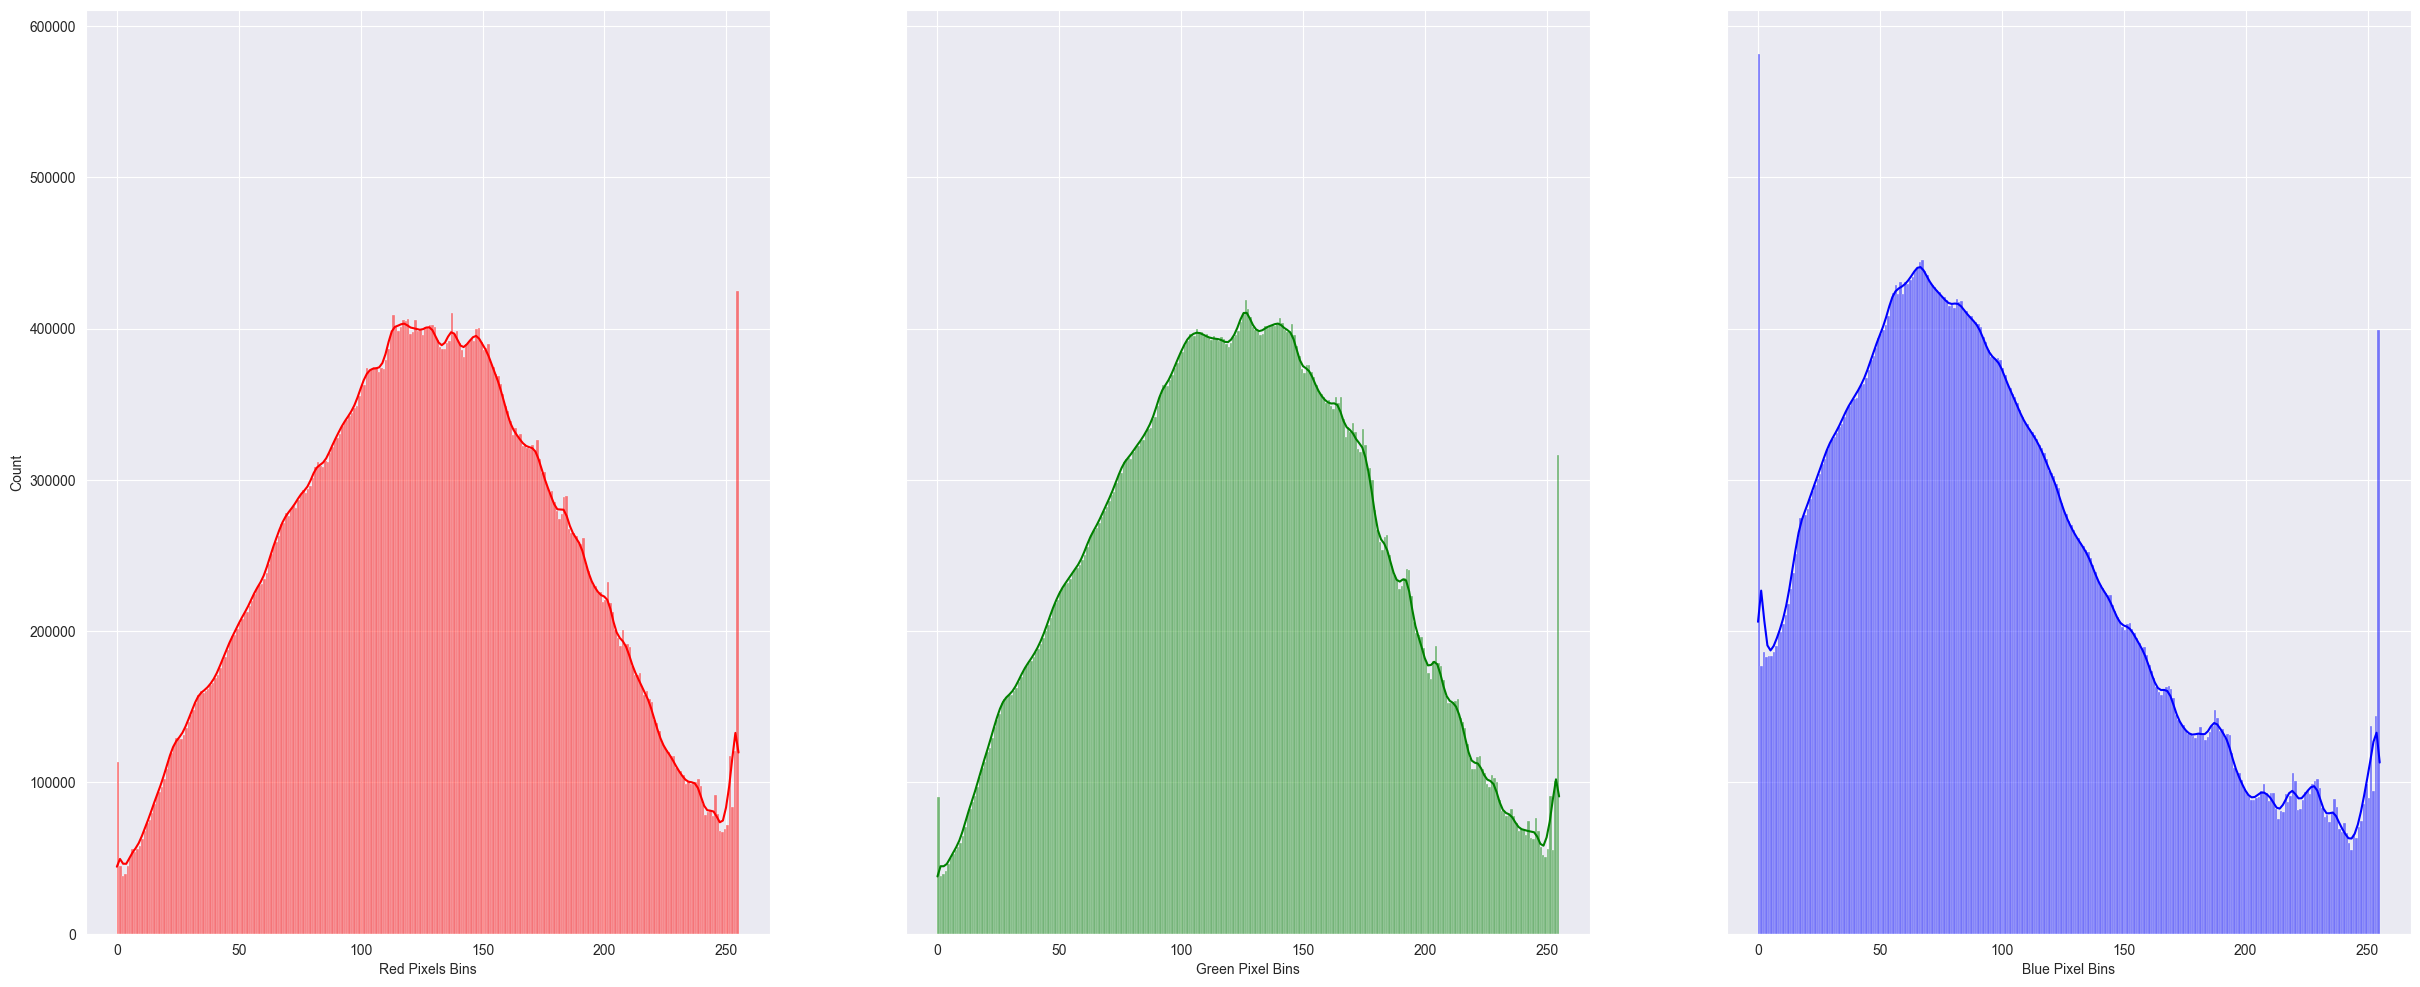

In [8]:
# using functions to limit scope of variables to make debugging easier and data overhead lesser.
# seaborn requires the raw data(may combine caching to be part of this function later)
def EDA(data,factor=8):
    nbins = math.ceil(255 / factor)
    red_channel_image_data_list = []
    green_channel_image_data_list = []
    blue_channel_image_data_list = []
    for index, row in data.iterrows():
        # read data set column of the given row
        dataset = row['data set']

        # read filepath col of the given row
        filepath = row['filepaths']
        # read label
        label = row['labels']
        # load image into computer vision using native image size(this data set has an universal image size)
        image = tf.keras.utils.load_img(filepath)
        # the image is 224x224x3 (width x height x color_channels)
        image_array = tf.keras.utils.img_to_array(image,data_format='channels_last')
                
        # group similar colors together to reduce computation time based on a constant value that can be adjusted
        image_array = image_array // factor # Reduce from 255x255x255 to 32x32x32, easier computation
        
        # 3D Slice colstart:colstop, rowstart:rowstop, depthstart:depthstop
        # Splitting the image_array into R, G, B channels
        red_channel = image_array[:, :, 0]
        green_channel = image_array[:, :, 1]
        blue_channel = image_array[:, :, 2]
        # gather raw and format data for seaborn plotting
        red_channel_image_data_list.append(red_channel)
        green_channel_image_data_list.append(green_channel)
        blue_channel_image_data_list.append(blue_channel)
        
    all_red_pixel_values = np.concatenate([image.ravel() for image in red_channel_image_data_list])
    all_green_pixel_values = np.concatenate([image.ravel() for image in green_channel_image_data_list])
    all_blue_pixel_values = np.concatenate([image.ravel() for image in blue_channel_image_data_list])    
    # Plots the smooth line
    # TODO: Reduce plot height
    fig, axes = plt.subplots(1, 3,figsize=(30,12), sharey=True)
    sns.histplot(all_red_pixel_values, ax=axes[0],bins=nbins, kde=True, color='red')
    sns.histplot(all_green_pixel_values,ax=axes[1], bins=nbins, kde=True, color='green')
    sns.histplot(all_blue_pixel_values, ax=axes[2],bins=nbins, kde=True, color='blue')

    # Setting x-axis labels for each subplot
    axes[0].set_xlabel('Red Pixels Bins')
    axes[1].set_xlabel('Green Pixel Bins')
    axes[2].set_xlabel('Blue Pixel Bins')
EDA(data,FACTOR)

# EDA Results
Putting color ranges into bins has had a negative effect on the smoothness of distrubtion line, but deemed nessary due to computational time otherwise.
Looking at the histograms, espically the blue pixel bins there is some deviation from the normal distrubtion.

## Lets use pre-computed histogram cache

In [3]:
#TODO: Integrate this better into the control flow of prior blocks
# read the modified spreadsheet that has the indexes to access the cache.
dataplus = pd.read_csv('birds_indexed.csv')
# a subset of dataplus with only the training data.
dataplus_trainset = dataplus[dataplus['data set'] == 'train']


# Pre-processing II
To help with calculating likeihood P(X|Y) = # pixels in bin x / # pixels in bin x for all given bird Y.
We are going to precompute # pixels in bin x for all given bird y. This will utitlize the pre-computed histograms. This will be store as a label : 3-tuple of arries in a dictionary.

In [5]:
def precompute_binTotals(df,factor=8):
    # this allows the program to calibrate the bin size depending on what "reduction factor" is.

    nbins = math.ceil(255 / factor)
    print('nbins:')
    print(nbins)
    # dictionaty to store the bin sums in an organized fashion
    targetBinSums = {}
    # dict to store std of a given bin
    targetStd = {}
    # to hold the histogram list form disk
    loaded_histogram_list = []
    with open('image_histograms.pkl', 'rb') as file:
        loaded_histogram_list = pickle.load(file)
    #find all possible target labels
    labels = sorted(list(df['labels'].unique())) # find all labels
    # calculate bin totals for each label
    for target in labels:
        redBinSums = [0]*nbins
        greenBinSums = [0]*nbins
        blueBinSums = [0]*nbins
        
        # compute subset dataframe of only the target bird rows
        targetdf = df[df['labels'] == target]
       
        # iterate through and calculate the bin totals
        for index,row in targetdf.iterrows():
            #grab the index from the csv and then convert from series to integer
            histoI = row['histogram_index']

            #grab the 3-tuple histograms from the list
            for histograms in loaded_histogram_list[histoI]:
                # iterate through the histograms (R,G,B histograms)
                for i in range(0,3):
                    # iterate through the histogram bins
                    for bi, bin  in enumerate(histograms[i]):
                        #red bin sums
                        if(i == 0):
                           redBinSums[bi] += bin 
                        # green bin sums
                        if(i == 1):
                            greenBinSums[bi] += bin
                        # blue bin sums
                        if(i == 2):
                            blueBinSums[bi] += bin
        # collect this information in a 3-tuple and use a dict to tie it to the target label
        targetBinSums[target] = [redBinSums,greenBinSums,blueBinSums]
    with open('targetBinSums.pkl', 'wb') as file:
        pickle.dump(targetBinSums, file)

precompute_binTotals(dataplus,FACTOR)


nbins:
255


In [15]:
def find_std(df,factor=8):
    with open('image_histograms.pkl', 'rb') as file:
        loaded_histogram_list = pickle.load(file)
    # dictionary to store the standard devitation of all an image's histograms.
    stdMasterDict = {}
    #find all possible target labels
    labels = sorted(list(df['labels'].unique())) # find all labels
    # calculate bin totals for each label
    for target in labels:
        # compute subset dataframe of only the target bird rows
        targetdf = df[df['labels'] == target]
        reds = []
        greens = []
        blues = []       
        for index,row in targetdf.iterrows():
            histoI = row['histogram_index']
            #grab the 3-tuple histograms from the list
            for histograms in loaded_histogram_list[histoI]:
                # iterate through the histograms (R,G,B histograms)
                for i in range(0,3):
                    # iterate through the histogram bins
                
                    for bi, bin  in enumerate(histograms[i]):
                        #red bin sums
                        if(i == 0):
                            reds.append(bin)
                        # green bin sums
                        if(i == 1):
                            greens.append(bin)
                        # blue bin sums
                        if(i == 2):
                            blues.append(bin)
            #calc std
            #TODO: This here finds the std dev of all bins of a given color rather than a given bin of a given a color.
            stdMasterDict[target] = [np.std(reds),np.std(greens),np.std(blues)]
        with open('stdMasterDict.pkl', 'wb') as file:
            pickle.dump(stdMasterDict, file)
find_std(dataplus,FACTOR)


## Calculate Prior
P(Y=y) where y is a given bird species. In this case it's the  (amount of samples = y / total smaples).
Calculate priors for all possible Y's.

In this case it's the amount of times the bird appears in the trainning set / total trainning set samples

In [7]:
def calculatePrior(df, Y):
    classes = sorted(list(df[Y].unique()))  # find all unique values in column Y
    prior = []
    for i in classes:  # for each unique value in Y
        prior.append(len(df[df[Y] == i]) / len(df))  # count Y=y occurrences / total samples
    return prior  # returns a list of target label priors

## Calculate P(X=x|Y=y) categorically
Given the discrete nature of the data guasian bayes is inapporiate.

In [6]:
def calculate_likelihood_categorical(df, colorbin, YBinValue):
    #df = df[df[Y]==label] # take only the rows where Y=label.
    #p_x_given_y = len(df[df[feat_name]==feat_val]) / (len(df))
    #take the current bin / that's bins total for all of label
    
    # add-one smoothing!
    colorbin += 1
    YBinValue += 1
    p_x_given_y = colorbin / YBinValue
    return p_x_given_y

## Guasian Attempt

In [26]:
def calculate_likelihood_gaussian(df,Y,bin, binTotal, std):
    #TODO: Figure out how to get standard devitation.
    df = df[df['labels'] == Y]
    mean = binTotal/(len(df)*(math.ceil(255 / FACTOR)))
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((bin-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y)
 for all y and find the maximum

In [27]:
def naive_bayes_categorical(df, test, Y):
    # load cached image pixel histograms
    features = []
    
    with open('image_histograms.pkl', 'rb') as file:
        features = pickle.load(file)
    # load cached bin totals for calculating likelihood
    with open('targetBinSums.pkl','rb') as file:
        targetBinSums = pickle.load(file)
    #std dev for gaussian
    with open('stdMasterDict.pkl','rb') as file:
        stdMasterDict = pickle.load(file)
    # calculate prior
    prior = calculatePrior(df, Y)

    Y_pred = []
    # loop over every data sample
    for index,row in test.iterrows():
         # likelihood = P(X|Y) in this case P(pixel bin x | target bird y)
        labels = sorted(list(test[Y].unique())) # find all labels
        likelihood = [1]*len(labels)
        
        # go through each class
        for j in range(len(labels)):
            # get histogram index as an integer from the row
            histoI = test['histogram_index'].iloc[0]
            #get the 3-tuple histogram, 1 per color channel
            for histograms in features[histoI]:
                # tracks the histogram(R[0],G[1],B[2])
                # get the individual histograms
                for colorI, histogram in enumerate(histograms): 
                    
                    # keeps track of current bin index
                    bi = int(0)
                    # get the bins from the histogram, the bins are the true features,
                    for colorbin in histogram:
                        # get the array of bins for the given color channel index of that belongs to the label
                        binSumArray = targetBinSums[labels[j]][colorI]
                        # get the sum bin of the given bin
                        binTotal = binSumArray[bi]
                        # categorical
                        # likelihood[j] *= calculate_likelihood_categorical(test, colorbin,binTotal)
                        # std for the given for gassuian
                        stdev = stdMasterDict[labels[j]][colorI]
                        # gassuian 
                        print('made it before gaussian')
                        likelihood[j] *= calculate_likelihood_gaussian(test, labels[j],colorbin,binTotal,stdev)
                        print('likelihood[j]:')
                        print(likelihood[j])
                        bi += 1
    
    # calculate posterior probability (numerator only)
    post_prob = [1]*len(labels)
    print('likelihood:')
    print(likelihood)
    print('post_prob:')
    print(post_prob)
    #print('likelihood:')
    #print(likelihood)
    for j in range(len(labels)):
        post_prob[j] = likelihood[j] * prior[j]
    print('post prob, post comp: ')
    print(post_prob)
    # 1 vs rest
    Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)
data_test = dataplus[dataplus['data set'] == 'test']
ret = naive_bayes_categorical(dataplus_trainset,data_test,'labels')
print(ret)

made it before gaussian
likelihood[j]:
3.279442268978748e-145
made it before gaussian
likelihood[j]:
1.7569353336623028e-174
made it before gaussian
likelihood[j]:
2.937983035646006e-192
made it before gaussian
likelihood[j]:
2.216675146241561e-202
made it before gaussian
likelihood[j]:
2.8373408813073037e-208
made it before gaussian
likelihood[j]:
9.132237655089195e-213
made it before gaussian
likelihood[j]:
1.2624861404862616e-216
made it before gaussian
likelihood[j]:
3.068079108890112e-220
made it before gaussian
likelihood[j]:
1.096278819996457e-223
made it before gaussian
likelihood[j]:
4.745001381617631e-227
made it before gaussian
likelihood[j]:
2.332335055674965e-230
made it before gaussian
likelihood[j]:
1.223457836031013e-233
made it before gaussian
likelihood[j]:
7.138897142358837e-237
made it before gaussian
likelihood[j]:
4.144947464206606e-240
made it before gaussian
likelihood[j]:
2.6475355224164537e-243
made it before gaussian
likelihood[j]:
1.7516912436600458e-246
mad

Placeholder for now. Seems like sklearn.metrics is what we are meant to be use. Which means sklearn integration somewhat.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values # all the other columns of a given row save the last(answer)
Y_test = test.iloc[:,-1].values # all the "answer/target" labels to each row
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))